In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/home/shibinbin/ibme/projects/Deepfold2


In [480]:
plt.rcParams['figure.dpi'] = 150
import scipy.stats
from sklearn.metrics import roc_auc_score, accuracy_score

In [13]:
sys.path.append('./bin')

In [226]:
import em
import imp
imp.reload(em)

<module 'em' from './bin/em.py'>

In [450]:
def hellinger_distance(p, q):
    return np.sqrt(np.sum(np.square(np.sqrt(p) - np.sqrt(q))))/np.sqrt(2)

p = scipy.stats.dirichlet(np.full(4, 0.5)).rvs(size=1)[0]
q = (p + 0.001)
q /= q.sum()
#q = scipy.stats.dirichlet(np.full(4, 0.5)).rvs(size=1)[0]
print('p =', p)
print('q =', q)
print(hellinger_distance(p, q))

p = [0.45374427 0.04997933 0.43825578 0.05802062]
q = [0.45293254 0.05077623 0.43750576 0.05878547]
0.001780476135690548


In [442]:
d = em.GaussianDistribution()
x = np.random.normal(size=1000)
weights = np.random.uniform(size=1000)
d.fit(x)
print(d.get_params())
d.fit(x, weights)
print(d.get_params())
print(np.sum(d.logL(x)))

{'mu': Parameter(-0.00897723), 'sigma': Parameter(0.98270022)}
{'mu': Parameter(-0.00389673), 'sigma': Parameter(0.97032941)}
-1401.6629258314056


optimized in 169 iterations
optimized in 179 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 146 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 134 iterations
optimized in 144 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 200 iterations
optimized in 190 iterations
optimized in 200 iterations
optimized in 109 iterations
optimized in 180 iterations
optimized in 200 iterations
{'p_mix': Parameter([0.20159708, 0.19913841, 0.07708677, 0.43895857, 0.08321917]), 'model[0]': {'mu': Parameter(8.03546363), 'sigma': Parameter(0.99644823)}, 'model[1]': {'mu': Parameter(4.05395542), 'sigma': Parameter(0.95000631)}, 'model[2]': {'mu': Parameter(0.78173379), 'sigma': Parameter(0.77217729)}, 'model[3]': {'mu': Parameter(-5.58925267), 'sigma': Parameter(2.6081471)}, 'model[4]': {'mu': Parameter(-0.26832308), 'sigma': Param

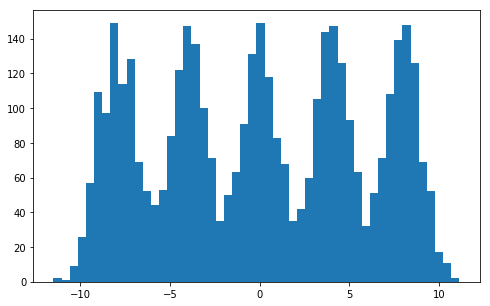

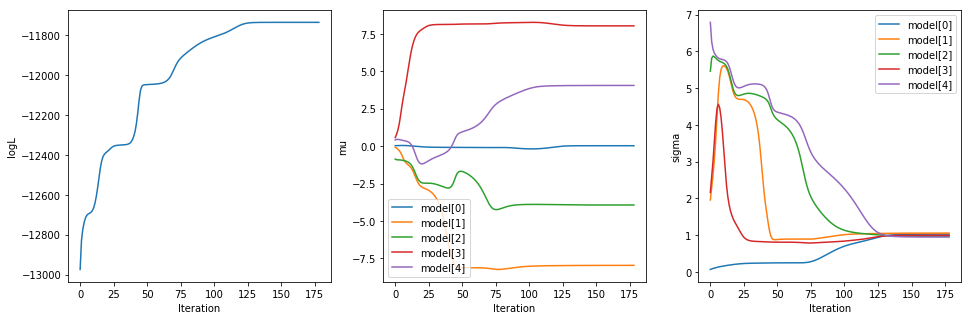

In [341]:
import em
import imp
imp.reload(em)

# create a mixture
n_components = 5
centers = [4*(i - n_components//2) for i in range(n_components)]
models = [em.GaussianDistribution(c, 1) for c in centers]
mixture = em.MixtureModel(models=models, p_mix=np.full(n_components, 1.0/n_components))
X = mixture.sample(size=4000)
fig, ax = plt.subplots(figsize=(8, 5))
h = ax.hist(X, bins=50)

mixture.init_params(components=True)
internals = mixture.fit(X, n_runs=20, max_iter=200, tol=1e-6, return_internal=True)
print(mixture.get_params())

logLs = np.asarray([internal['logL'] for internal in internals])
mus = {}
sigmas = {}
for i in range(len(models)):
    mus[i] = np.asarray([internal['params']['model[%d]'%i]['mu'] for internal in internals])
    sigmas[i] = np.asarray([internal['params']['model[%d]'%i]['sigma'] for internal in internals])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].plot(logLs)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('logL')
      
for i in range(len(models)):
    axes[1].plot(mus[i], label='model[%d]'%i)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('mu')
axes[1].legend()

for i in range(len(models)):
    axes[2].plot(sigmas[i], label='model[%d]'%i)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('sigma')
axes[2].legend()

In [289]:
internals[7]['params']

{'model[0]': {'mu': Parameter(-0.04610346), 'sigma': Parameter(10.60618416)},
 'model[1]': {'mu': Parameter(0.53024084), 'sigma': Parameter(3.92398679e-12)},
 'model[2]': {'mu': Parameter(-0.04610386), 'sigma': Parameter(10.6061836)},
 'p_mix': Parameter([3.15098874e-01, 2.04576475e-16, 6.84901126e-01])}

In [493]:
import em
import imp
imp.reload(em)
from em import PwmModel, BackgroundModel, MixtureModel

n_seqs = 4000
p_mix = np.asarray([0.8, 0.2])
n_seqs_pwm = int(n_seqs*p_mix[1])
n_seqs_bg = n_seqs - n_seqs_pwm
length = 10
# Test the PWM model
pwm = PwmModel(length=length)
pwm.init_params()
X_pwm = pwm.sample(size=n_seqs_pwm)
p_pwm = pwm.get_params()['pwm']
weights_pwm = np.random.uniform(size=X_pwm.shape[0])
pwm.fit(X_pwm, weights=weights_pwm)
p_pwm_estim = pwm.get_params()['pwm']
d = np.mean([hellinger_distance(p, q) for p, q in zip(p_pwm, p_pwm_estim)])
print('Distance between PWM and estimated parameters:', d)
# Test the background model
bg = BackgroundModel(length=length)
bg.init_params()
X_bg = bg.sample(size=n_seqs_bg)
p_bg = bg.get_params()['p']
weights_bg = np.random.uniform(size=X_bg.shape[0])
pwm.fit(X_bg, weights=weights_bg)
bg.fit(X_bg)
p_bg_estim = bg.get_params()['p']
d = np.mean([hellinger_distance(p, q) for p, q in zip(p_bg, p_bg_estim)])
print('Distance between PWM and estimated parameters:', d)

X_mix = np.concatenate([X_bg, X_pwm], axis=0)
y_mix = np.concatenate([np.zeros(X_bg.shape[0], dtype=np.int32),
                        np.ones(X_pwm.shape[0], dtype=np.int32)])
random_indices = np.random.permutation(X_mix.shape[0])
X_mix = np.take(X_mix, random_indices, axis=0)
y_mix = np.take(y_mix, random_indices, axis=0)
del random_indices
# create a mixture model
mixture = MixtureModel(models=[em.BackgroundModel(length=length),
                                  em.PwmModel(length=length)])
mixture.init_params(components=True)
results = mixture.fit(X_mix, max_iter=200)
print('Estimated mixture parameters:', mixture.get_params())
# compare estimated parameters with true smodels
p_mix_estim = mixture.get_params()['p_mix']
d = np.mean([hellinger_distance(p, q) for p, q in zip(p_mix, p_mix_estim)])
print('Distance between mixture coefficient and estimated parameters:', d)
p_bg_estim = mixture.get_params()['model[0]']['p']
d = np.mean([hellinger_distance(p, q) for p, q in zip(p_bg, p_bg_estim)])
print('Distance between mixture background and estimated parameters:', d)
p_pwm_estim = mixture.get_params()['model[1]']['pwm']
d = np.mean([hellinger_distance(p, q) for p, q in zip(p_pwm, p_pwm_estim)])
print('Distance between mixture PWM and estimated parameters:', d)
# evaluate prediction performance
posteriors = mixture.posteriors(X_mix)
roc_auc_pwm = roc_auc_score(y_mix, posteriors[:, 1])
print('ROAUC of PWM posteriors:', roc_auc_pwm)
y_pwm_pred = mixture.predict(X_mix)
accuracy_pwm = roc_auc_score(y_mix, y_pwm_pred)
print('Accuracy of PWM prediction:', accuracy_pwm)

Distance between PWM and estimated parameters: 0.029389503828269846
Distance between PWM and estimated parameters: 0.0006656391546244901
optimized in 14 iterations, logL = -50700.62595130697
optimized in 14 iterations, logL = -50700.62596385961
optimized in 14 iterations, logL = -50700.62608866611
optimized in 13 iterations, logL = -50700.6259088756
optimized in 14 iterations, logL = -50700.626176775986
optimized in 19 iterations, logL = -50700.62610353339
optimized in 14 iterations, logL = -50700.626306950704
optimized in 14 iterations, logL = -50700.625982694066
optimized in 13 iterations, logL = -50700.62628901727
optimized in 18 iterations, logL = -50700.626290022454
Estimated mixture parameters: {'p_mix': Parameter([0.80348704, 0.19651296]), 'model[0]': {'p': Parameter([0.34602715, 0.18979958, 0.24950734, 0.21466593])}, 'model[1]': {'pwm': Parameter([[7.82955335e-03, 7.86663136e-02, 4.74064155e-01,
            4.39439978e-01],
           [1.98745034e-01, 1.63737233e-02, 7.82742407

In [502]:
def read_transfac(filename, alphabet='AUCG'):
    record = {}
    with open(filename, 'r') as f:
        pfm = {}
        for line in f:
            tag = line[:2]
            if tag in ('XX', '//'):
                continue
            content = line[3:].strip()
            if tag.isdigit():
                pfm[int(tag)] = [float(a) for a in content.split()]
            elif tag == 'PO':
                record[tag] = content.split()
                record[tag] = [a.replace('T', 'U') for a in record[tag]]
            else:
                record[tag] = content
        alphabet_order = np.argmax(np.asarray(record['PO'])[:, np.newaxis] == np.asarray(list(alphabet), dtype='U1'), axis=1)
        #alphabet_order = np.arange(len(alphabet))
        pfm = [pfm[i] for i in range(1, len(pfm) + 1)]
        pfm = np.asarray(pfm)
        pfm = pfm[:, alphabet_order]
        record['LEN'] = pfm.shape[0]
        record['PFM'] = pfm
        record['NSEQ'] = sum(pfm[0])
        p = (pfm + 1)/np.sum(pfm + 1, axis=1, keepdims=True)
        record['PWM'] = p[:, alphabet_order]
        record['INFOBIT'] = -np.sum(p*np.log(p))
    return record

class Onehot(object):
    def __init__(self, alphabet='AUCG'):
        self.alphabet = np.asarray(list(alphabet), dtype='U1')

    def encode(self, s):
        x = np.asarray(list(s), dtype='U1')
        encoded = (x[:, np.newaxis] == self.alphabet[np.newaxis, :]).astype(np.int32)
        return encoded

    def decode(self, x):
        return ''.join(self.alphabet[np.argmax(x, axis=1)])
    
def fasta_to_onehot(filename, motif_only=False, return_names=False):
    '''Read a FASTA file and convert the sequences to onehot encoding
    Args:
        motif_only: parse motif position from sequence name and extract only motif instances
        parse_label: parser the sequence names to determine whether the sequence is random
    Returns:
        ndarray of shape (n_sequences, seq_length, alphabet_size)
    '''
    from Bio import SeqIO

    onehot = Onehot()
    dataset = []
    names = []
    for record in SeqIO.parse(filename, 'fasta'):
        if motif_only:
            start, end = [int(a) for a in record.id.split('/')[1].split('-')]
            start -= 1
            dataset.append(onehot.encode(str(record.seq)[start:end])[np.newaxis, :, :])
        else:
            dataset.append(onehot.encode(str(record.seq))[np.newaxis, :, :])
        if return_names:
            names.append(record.id)
    lengths = np.asarray([a.shape[1] for a in dataset])
    max_length = np.max(lengths)
    if not np.all(lengths == max_length):
        dataset_container = np.zeros((len(dataset), max_length, 4), dtype=np.int32)
        for i, a in enumerate(dataset):
            dataset_container[i, :a.shape[1], :] = a[0]
        dataset = dataset_container
    else:
        dataset = np.concatenate(dataset, axis=0)
    if return_names:
        return dataset, names
    else:
        return dataset

def sequences_to_windows(X, window_size):
    lengths = np.asarray([(x.shape[0] - window_size + 1) for x in X])
    ends = np.cumsum(lengths)
    starts = ends - lengths
    n_windows = np.sum(lengths)
    X_split = np.empty((n_windows, window_size, X[0].shape[1]), dtype=X[0].dtype)
    i = 0
    for x in X:
        for j in range(x.shape[0] - window_size + 1):
            X_split[i] = x[j:(j + window_size)]
            i += 1
    return X_split, starts, ends

X_jaspar, names = fasta_to_onehot('output/jaspar_sample/seq/128/MA0028.2.fa', return_names=True)
window_size = X_jaspar.shape[1]
positions = np.asarray([a.split('/')[1].split('-')[0] for a in names], dtype=np.int32) - 1
transfac = read_transfac('data/JASPAR/vertebrates/MA0028.2.transfac')
motif_length = transfac['LEN']
np.asarray(list('AUCG'))[np.argmax(transfac['PWM'], axis=1)]

In [537]:
transfac['PWM']

array([[6.81281418e-01, 8.50560695e-02, 4.09143639e-02, 1.92748148e-01],
       [2.49887161e-02, 4.86233638e-03, 9.39805507e-01, 3.03434410e-02],
       [7.78378378e-03, 4.75675676e-04, 9.90443243e-01, 1.29729730e-03],
       [2.18064460e-05, 5.88774042e-04, 4.79741812e-04, 9.98909678e-01],
       [1.07367562e-04, 1.53320879e-02, 9.01887522e-04, 9.83658657e-01],
       [9.92998201e-01, 5.63612321e-04, 5.07251089e-03, 1.36567601e-03],
       [9.47052864e-01, 4.47807480e-02, 6.90524923e-03, 1.26113833e-03],
       [5.86030069e-02, 5.73015811e-03, 4.58801134e-02, 8.89786722e-01],
       [1.69316272e-02, 8.45805868e-01, 1.16508798e-01, 2.07537067e-02],
       [2.89777564e-01, 1.87465892e-01, 1.45685534e-01, 3.77071009e-01]])

optimized in 106 iterations, logL = -304752.1668083137
optimized in 46 iterations, logL = -304355.7057445431
optimized in 43 iterations, logL = -304365.35628721537
optimized in 34 iterations, logL = -304365.3565341633
optimized in 21 iterations, logL = -304266.4505972411
optimized in 54 iterations, logL = -304667.43960420025
optimized in 56 iterations, logL = -304334.42595889815
optimized in 122 iterations, logL = -304752.16648330603
optimized in 96 iterations, logL = -304752.1673213705
optimized in 59 iterations, logL = -304458.5208836984
optimized in 51 iterations, logL = -304318.288592417
optimized in 57 iterations, logL = -304409.64012152713
optimized in 62 iterations, logL = -304313.2619667769
optimized in 34 iterations, logL = -304365.35623663437
optimized in 27 iterations, logL = -304355.7057988505
optimized in 58 iterations, logL = -304334.42591989745
optimized in 57 iterations, logL = -304318.2884196613
optimized in 86 iterations, logL = -304667.43958349223
optimized in 300 it

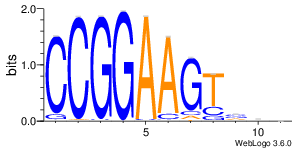

In [624]:
discover_length = 11
X_jaspar_windows, starts, ends = sequences_to_windows(X_jaspar, discover_length)
mixture = MixtureModel(models=[em.BackgroundModel(length=discover_length),
                               em.PwmModel(length=discover_length)])
mixture.init_params(components=True)
results = mixture.fit(X_jaspar_windows[:20000], n_runs=20, max_iter=300)
#print(hellinger_distance(mixture.get_params()['model[1]']['pwm'], transfac['PWM']))

from wand.image import Image as WImage
from io import BytesIO
pdf = pwm_weblogo((100000*mixture.get_params()['model[1]']['pwm']).astype(np.int32),
                  'PWM', output_format='pdf')
WImage(file=BytesIO(pdf), format='pdf', resolution=100)

In [533]:
mixture.get_params()

{'model[0]': {'p': Parameter([0.25395175, 0.23753635, 0.25161133, 0.25690058])},
 'model[1]': {'pwm': Parameter([[2.42403075e-01, 2.43211931e-01, 2.56374436e-01,
              2.58010558e-01],
             [2.55859394e-01, 2.39668851e-01, 2.50535905e-01,
              2.53935850e-01],
             [2.47740264e-01, 2.49578089e-01, 2.54174673e-01,
              2.48506974e-01],
             [6.87986038e-01, 2.67940392e-03, 2.35407339e-01,
              7.39272192e-02],
             [2.63222239e-02, 4.70471333e-04, 9.42865446e-01,
              3.03418590e-02],
             [3.14291880e-03, 2.24512159e-04, 9.96628140e-01,
              4.42954312e-06],
             [2.95483547e-08, 1.02782232e-06, 4.51901515e-08,
              9.99998897e-01],
             [3.94674979e-13, 1.51972388e-02, 8.23777303e-05,
              9.84720383e-01],
             [9.94947494e-01, 2.86258395e-04, 4.76599103e-03,
              2.56678363e-07],
             [9.51248338e-01, 2.57996748e-13, 4.87409154e-02,
 

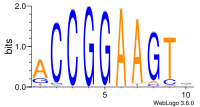

In [553]:
import subprocess
from io import BytesIO
from IPython.display import SVG
p = subprocess.Popen(['weblogo', '-D' 'transfac', '-F', 'svg', '-s' 'large',
                     '-f' 'data/JASPAR/vertebrates/MA0028.2.transfac'],
                     stdout=subprocess.PIPE)
weblogo, _ = p.communicate()
SVG(weblogo)

In [610]:
def counts_to_transfac(counts, name, species_name='unknown', alphabet='ATCG'):
    '''Convert counts to transfac format
    Args:
        counts: ndarray of shape (length, alphabet_size)
    '''
    column_width =  max(int(np.ceil(np.log10(counts.shape[0]))),
                        int(np.ceil(np.log10(np.max(counts)))))
    body_format = '{:0>2d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}'
    header_format = '{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}'
    counts = counts.astype(np.int32)
        
    lines = []
    lines.append('ID {}'.format(name))
    lines.append('BF {}'.format(species_name))
    lines.append(header_format.format('PO', *list(alphabet), width=column_width))
    #lines.append('//')
    for pos, counts_row in zip(range(1, counts.shape[0] + 1), counts):
        lines.append(body_format.format(pos, *counts_row, width=column_width))
    return '\n'.join(lines)

def pwm_weblogo(counts, name, species_name='unknown', alphabet='ATCG', output_format='png'):
    '''Convert counts to WebLogo (SVG format)
    Args:
        counts: ndarray of shape (length, alphabet_size)
    Returns:
        svg script
    '''
    column_width =  max(int(np.ceil(np.log10(counts.shape[0]))),
                        int(np.ceil(np.log10(np.max(counts)))))
    body_format = '{:0>2d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}'
    body_format = '{:0>2d}\t{:<{width}.1f}\t{:<{width}.1f}\t{:<{width}.1f}\t{:<{width}.1f}'
    header_format = '{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}'
    counts = counts.astype(np.int32)
        
    lines = []
    lines.append('ID {}'.format(name))
    lines.append('XX')
    lines.append('BF {}'.format(species_name))
    lines.append('XX')
    lines.append(header_format.format('PO', *list(alphabet), width=column_width))
    #lines.append('//')
    for pos, counts_row in zip(range(1, counts.shape[0] + 1), counts):
        lines.append(body_format.format(pos, *counts_row, width=column_width))
    lines.append('XX')
    lines.append('//')
    transfac = '\n'.join(lines)
    #print(transfac)
    
    p = subprocess.Popen(['weblogo', '-D' 'transfac', '-F', output_format, '-s', 'large'],
                     stdin=subprocess.PIPE,
                     stdout=subprocess.PIPE)
    weblogo_svg, _ = p.communicate(bytearray(transfac, encoding='UTF-8'))
    #weblogo_svg = str(weblogo_svg, encoding='UTF-8')
    return weblogo_svg

In [529]:
mixture.get_params()['model[1]']['pwm'].shape

(12, 4)

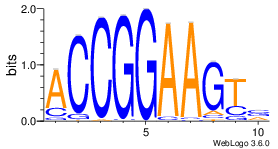

In [611]:
from wand.image import Image as WImage
from io import BytesIO
pdf = pwm_weblogo((100000*mixture.get_params()['model[1]']['pwm']).astype(np.int32),
                  'PWM', output_format='pdf')
WImage(file=BytesIO(pdf), format='pdf', resolution=100)

In [606]:
WImage?

In [520]:
np.round(mixture.get_params()['p_mix'][0]/mixture.get_params()['p_mix'][1])

123.0

In [522]:
y_pred = mixture.predict(X_jaspar_windows)

In [524]:
y_pred.sum()

Parameter(4965)

In [2]:
import numba
import numpy as np
@numba.jit('float32[:](float32[:], float32[:])')
def Add(a, b):
    c = np.empty(a.shape[0])
    for i in range(a.shape[0]):
        c[i] = a[i] + b[i]
    return c

a = np.arange(0, 10, dtype=np.float32)
b = np.arange(10, 20, dtype=np.float32)
Add(a, b)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28.])